In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import random
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install split-folders
import splitfolders

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

print(f"TensorFlow version: {tf.__version__}")

--2023-12-26 15:44:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-26 15:44:42 (72.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]

TensorFlow version: 2.15.0


In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model_halal = load_model("/content/drive/MyDrive/Colab Notebooks/Models/fyp_halal_model_fine_tuned2.h5")
model_haram = load_model("/content/drive/MyDrive/Colab Notebooks/Models/fyp_haram_model.h5")
model_soil = load_model("/content/drive/MyDrive/Colab Notebooks/Models/fyp_soil_classification_model_fine_tuned.h5")

In [5]:
model_halal.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 19)                24339     
                                                             

In [6]:
model_haram.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 21)                26901     
                                                             

In [7]:
model_soil.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                             

In [8]:
class_names_halal = ['Big Raho Fish',
              'Black Water Rahu',
              'Cat Fish',
              'Dhari Fish',
              'Dilwar Fish',
              'Heera Fish',
              'Jalabi Paplet Fish',
              'Moi Fish',
              'Naiser Fish',
              'Paplet Fish',
              'Parrot Fish',
              'Rahu Fish',
              'Red Snapper Fish',
              'Ringi Cat Fish',
              'Safi Fish',
              'Sarum Fish',
              'Silver Carp Fish',
              'Tacan Fish',
              'Zandia or Dhandia Fish']

In [9]:
len(class_names_halal)

19

In [10]:
class_names_haram = ['Angel Fish',
 'Black Ghost Knife Fish',
 'Blue Line Shark',
 'Carp',
 'Catfish',
 'Clownfish (Nemo)',
 'Demasoni Cichlid',
 'Diamond Carp',
 'Green Severum',
 'King Firefish',
 'Kite Fish',
 'KoiQue',
 'Mono Angel',
 'Oscar Fish',
 'Pirate Chiplet',
 'Red Jewel',
 'Red Tetratick',
 'ShrimpChiplet',
 'Skate Fish',
 'Tekra Family',
 'TictletChiplet (color variants)']

In [11]:
len(class_names_haram)

21

In [12]:
class_names_soil = ['Kahra zameen',
                    'MIX',
                    'Mitha pani ki zameen']

In [13]:
len(class_names_soil)

3

In [14]:
test_dir_halal = '/content/drive/MyDrive/Halal Fish Dataset Full/SPLITTED_DATASET/test'
test_dir_haram = '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test'
test_dir_soil = '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test'

In [15]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [16]:
# Make preds on a series of random images
def make_preds(m, class_names, test_dir):
  plt.figure(figsize=(17, 10))
  for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = m.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

1/1 [==============================] - 0s 126ms/step


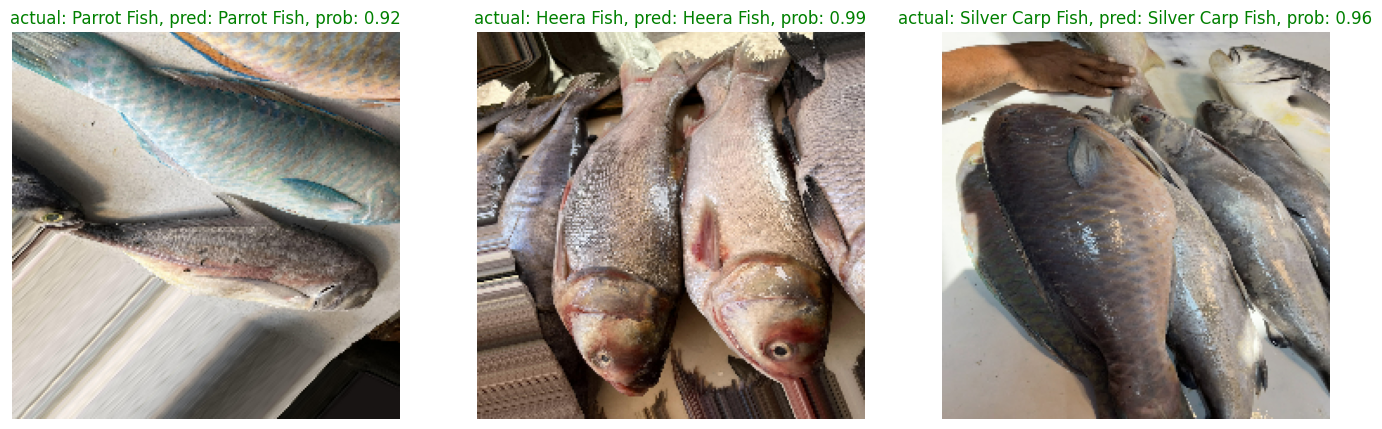

In [17]:
make_preds(model_halal, class_names_halal, test_dir_halal)

1/1 [==============================] - 0s 106ms/step


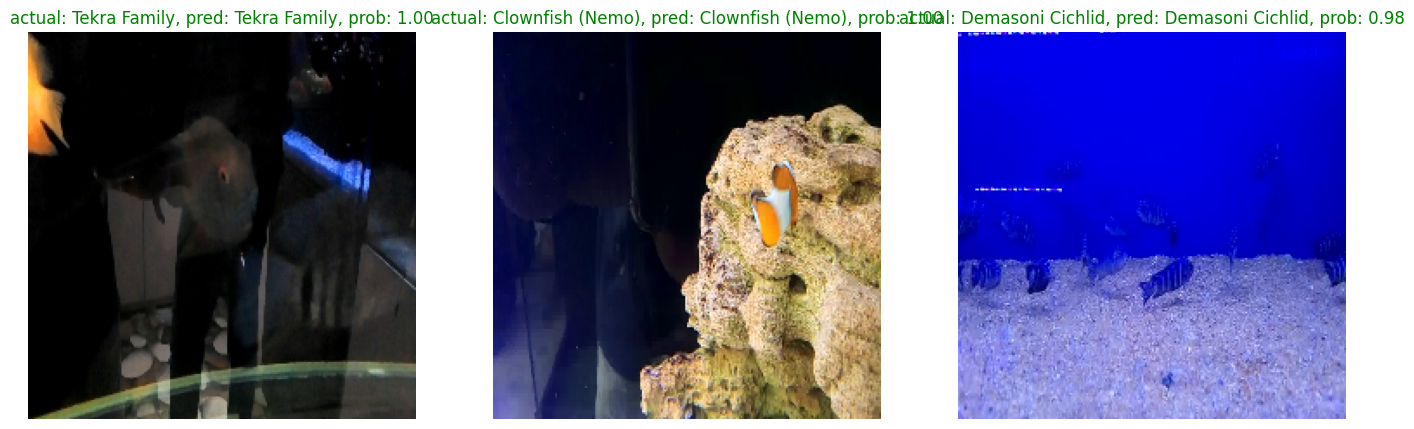

In [18]:
make_preds(model_haram, class_names_haram, test_dir_haram)

1/1 [==============================] - 0s 88ms/step


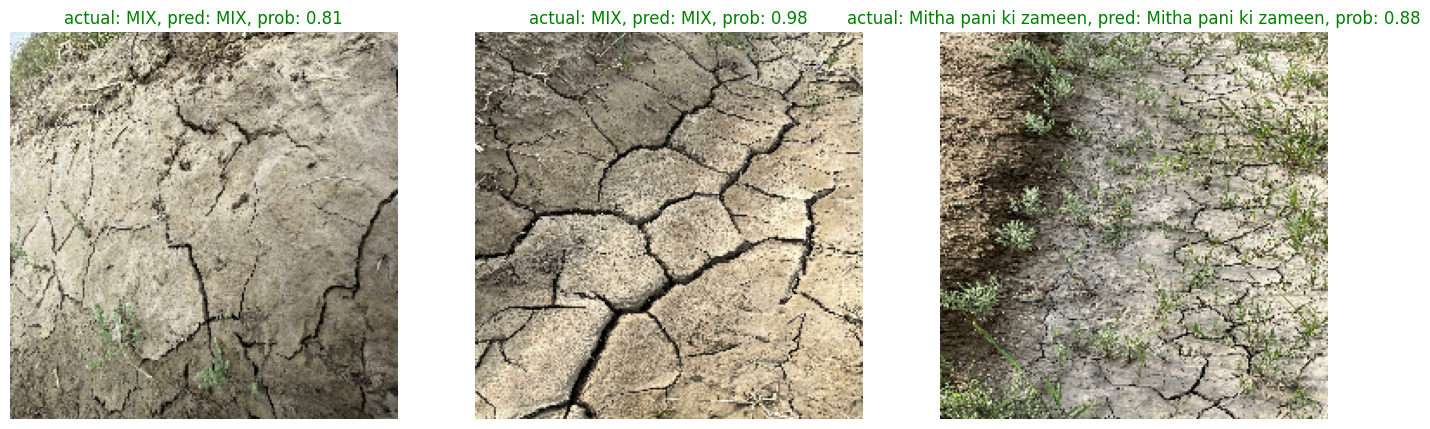

In [19]:
make_preds(model_soil, class_names_soil, test_dir_soil)